In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [1]:
import sys, os, sys
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import init
jaxm = init(device="cuda", dtype="double")

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn
from pmpc.experimental import scp_solve
print(jaxm.zeros(()).dtype)
print(jaxm.zeros(()).device())

float64
gpu:0


In [2]:
def f_fx_fu_fn(X_prev, U_prev):
    X_prev, U_prev = np.array(X_prev), np.array(U_prev)
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

In [7]:
M, N, xdim, udim = 1000, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=3e0)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

In [9]:
X, U, data = scp_solve(*args, max_it=50, res_tol=1e-12, **opts, solver_settings=dict(smooth_alpha=1e2))

+------+------------+------------+------------+------------+------------+----------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |  alpha   |
+------+------------+------------+------------+------------+------------+----------+
| 0001 |  6.516e-01 |  5.291e+01 |  2.022e+00 |  3.000e+00 |  1.000e-02 |  1.0e-01 |
| 0002 |  1.001e+00 |  1.450e+00 |  2.388e-01 |  3.000e+00 |  1.000e-02 |  1.0e+00 |
| 0003 |  1.324e+00 |  6.287e-01 |  3.005e-01 |  3.000e+00 |  1.000e-02 |  1.0e+01 |
| 0004 |  1.725e+00 |  8.512e-01 |  3.918e-01 |  3.000e+00 |  1.000e-02 |  1.0e+02 |
| 0005 |  2.263e+00 |  7.974e-01 |  2.687e-01 |  3.000e+00 |  1.000e-02 |  1.0e+02 |
| 0006 |  2.926e+00 |  7.696e-01 |  3.819e-01 |  3.000e+00 |  1.000e-02 |  1.0e+02 |
| 0007 |  3.547e+00 |  7.535e-01 |  2.871e-01 |  3.000e+00 |  1.000e-02 |  1.0e+02 |
| 0008 |  4.255e+00 |  7.441e-01 |  1.565e-01 |  3.000e+00 |  1.000e-02 |  1.0e+02 |
| 0009 |  4.786e+00 |  7.389e-01 |  1.261e-01 |  3.000e+00 |  1.0

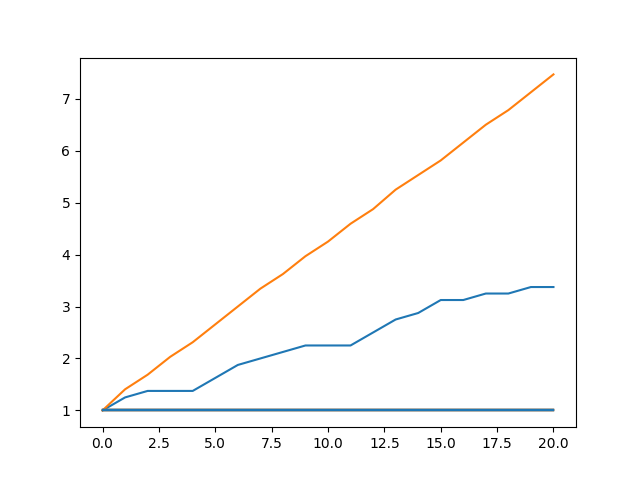

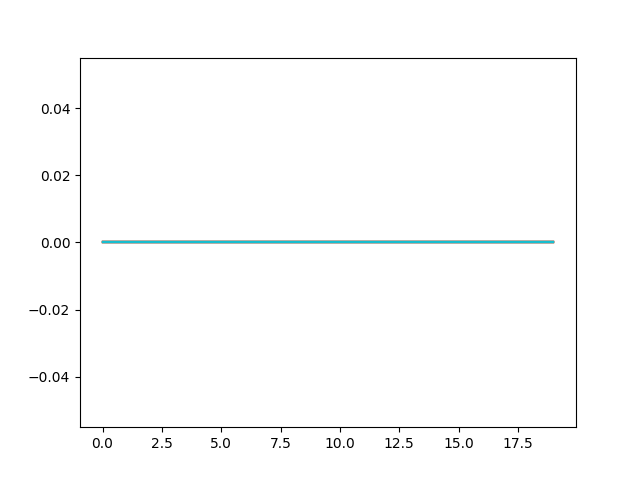

In [10]:
idx = 0
plt.figure(4356675)
plt.clf()
for r in range(X.shape[1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

In [ ]:
for solver in ["ecos", "osqp", "cosmo"]:
    #ret = pmpc.tune_scp(*args, **opts)
    #opts["reg_x"], opts["reg_u"] = ret
    opts["solver_settings"] = dict(solver=solver)
    X, U, data = pmpc.solve(*args, max_it=100, **opts)
    #X, U = X[0], U[0]

    #ret = pmpc.tune_scp(*args, solve_fn=pmpc.accelerated_scp_solve, **opts)
    #opts["reg_x"], opts["reg_u"] = ret
    #X, U, data = pmpc.accelerated_scp_solve(*args, max_iters=100, **opts)
    #X, U = X[0], U[0]

    plt.figure()
    plt.title(solver)
    for r in range(xdim):
        plt.plot(X[:, r], label="$x_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.title(solver)
    for r in range(udim):
        plt.plot(U[:, r], label="$u_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

plt.show()